<a href="https://colab.research.google.com/github/Lorxus/SERI-MATS-Summer-2023/blob/main/MNIST_for_SERI_MATS_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import some stuff
import torch
import torchvision
import scipy
import functorch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.autograd import Variable
from numpy.core.fromnumeric import prod
import matplotlib.pyplot as plt

!git clone https://github.com/noahgolmant/pytorch-hessian-eigenthings

import os
os.chdir("/content/")
print(os.getcwd())

import sys
sys.path.append('/content/pytorch-hessian-eigenthings/')
from hessian_eigenthings import *
print(lanczos)

Cloning into 'pytorch-hessian-eigenthings'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 210 (delta 34), reused 25 (delta 25), pack-reused 166
Receiving objects: 100% (210/210), 60.05 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content
<function lanczos at 0x7f15cacec670>


In [ ]:
#define model
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#from torch.nn.modules.activation import Softmax
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
#define optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)
params = optimizer.param_groups[0]['params']

for mx in model.parameters():
  print(mx.shape)

#calculating total final matrix side length
dim = 0
for mx in params:
  if not mx.flatten().shape == mx.shape:
    tmp = mx.flatten().shape
    dim += mx.flatten().shape[0]

print(f"Parameter space dimension: {dim}")

torch.Size([32, 784])
torch.Size([32])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
Parameter space dimension: 27776


In [ ]:
#define loss
loss = nn.CrossEntropyLoss()

In [ ]:
#split data into training and test values
train_data = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.ToTensor())
train, val = random_split(train_data, [55000, 5000])
train_loader = DataLoader(train, batch_size = 32)
val_loader = DataLoader(val, batch_size = 32)

100%|██████████| 9912422/9912422 [00:00<00:00, 75542207.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18460178.88it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23625011.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1649253.64it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#training epochs
nb_epochs = 11
a = list()
l = list()
for epoch in range(nb_epochs):
  losses = list()
  accuracies = list()
  loss_tot = 0
  for batch in train_loader:
      x, y = batch

      # x: b x 1 x 28 x 28
      # the "1" here is bc grayscale - if it were rgb it'd be 3
      b = x.size(0)
      x = x.view(b, -1)

      #step 1: forward
      M = model(x) #logits

      #step 2: compute obj fcn
      L = loss(M, y)

      #step 3: clean up the gradients so we can recalc
      #params.grad._zero()
      model.zero_grad()

      #step 4: "accumulate" the [del J / del param_i]s/propagate changes "backwards" in the AD graph
      L.backward()
      #params.grad.sum_(dJ/dparams)

      #step 5: step against the gradient
      optimizer.step()

      losses.append(L.item())
      loss_tot += L.item()
      accuracies.append(y.eq(M.detach().argmax(dim=1).cpu()).float().mean())
  a.append(torch.tensor(accuracies).mean())
  l.append(torch.tensor(losses).mean())

  print(f'Epoch {epoch + 1}', end = ', ')
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end = ', ')
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}', end = ', ')
  print(f'total loss: {loss_tot:.2f}')

Epoch 1, training loss: 1.15, training accuracy: 0.68, total loss: 1984.52
Epoch 2, training loss: 0.40, training accuracy: 0.89, total loss: 687.76
Epoch 3, training loss: 0.33, training accuracy: 0.91, total loss: 558.95
Epoch 4, training loss: 0.29, training accuracy: 0.92, total loss: 497.60
Epoch 5, training loss: 0.27, training accuracy: 0.92, total loss: 456.93
Epoch 6, training loss: 0.25, training accuracy: 0.93, total loss: 423.92
Epoch 7, training loss: 0.23, training accuracy: 0.93, total loss: 394.28
Epoch 8, training loss: 0.21, training accuracy: 0.94, total loss: 367.49
Epoch 9, training loss: 0.20, training accuracy: 0.94, total loss: 343.66
Epoch 10, training loss: 0.19, training accuracy: 0.95, total loss: 322.69
Epoch 11, training loss: 0.18, training accuracy: 0.95, total loss: 304.12


In [ ]:
#validation loops
model.eval()
losses = list()
accuracies = list()
for batch in val_loader:
    x, y = batch

    # x: b x 1 x 28 x 28
    # the "1" here is bc grayscale - if it were rgb it'd be 3
    b = x.size(0)
    x = x.view(b, -1)

    #step 1: forward
    with torch.no_grad():
      M = model(x) #logits

    #step 2: compute obj fcn
    L = loss(M, y)

    losses.append(L)
    accuracies.append(y.eq(M.detach().argmax(dim=1).cpu()).float().mean())
print(f'Epoch {epoch + 2}', end = ', ')
print(f'validation loss: {torch.tensor(losses).mean():.2f}', end = ', ')
print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 12, validation loss: 0.18, validation accuracy: 0.95


Text(0.5, 1.0, '')

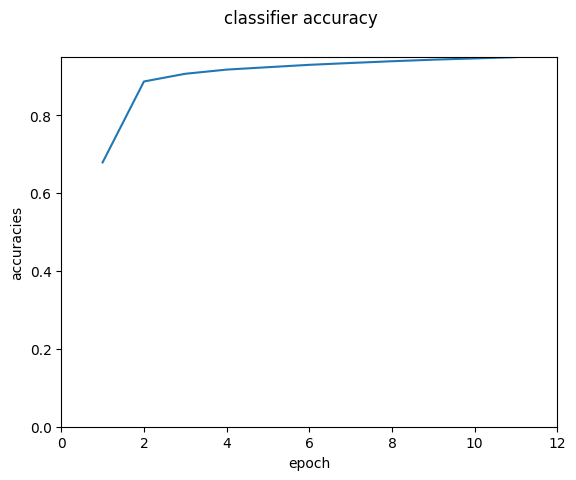

In [ ]:
###BEGIN PLOT TEMPLATE
# DATA TO PLOT
x = range(1, 12)
y = a

# PLOTTING PARAMETERS
x_min = 0
x_max = 12
y_min = 0
y_max = max(a)
x_label = "epoch"
y_label = "accuracies"
plot_title = "classifier accuracy"
plot_subtitle = ""

# PLOT COMMANDS
plt.figure()
plt.plot(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.suptitle(plot_title)
plt.title(plot_subtitle)
### END PLOT TEMPLATE

In [ ]:
num_eigens = 24

eigenvals, eigenvecs = compute_hessian_eigenthings(model, val_loader,
                                                   loss, num_eigens, use_gpu=False)

print(eigenvals)


 [=============================================================>...]  Step: 840ms | Tot: 16s973ms | power iter error: 0.0001 20/20 
 [=============================================================>...]  Step: 824ms | Tot: 16s686ms | power iter error: 0.0001 20/20 
 [=============================================================>...]  Step: 884ms | Tot: 19s854ms | power iter error: 0.0002 20/20 
 [=============================================================>...]  Step: 848ms | Tot: 17s524ms | power iter error: 0.0042 20/20 
 [=============================================================>...]  Step: 852ms | Tot: 16s778ms | power iter error: 0.0018 20/20 
 [=============================================================>...]  Step: 843ms | Tot: 1

RuntimeError: ignored

Text(0.5, 1.0, '')

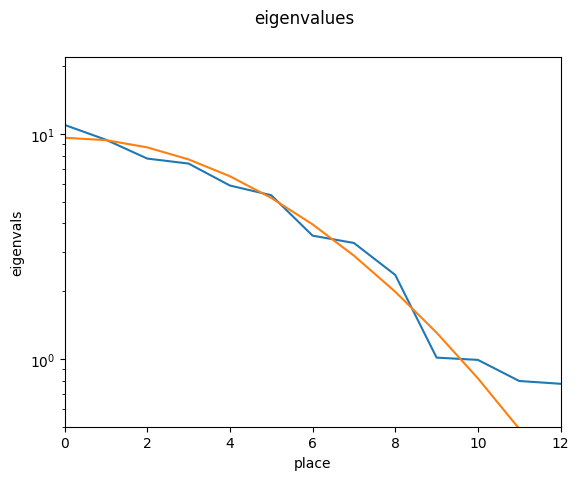

In [ ]:
###BEGIN PLOT TEMPLATE
# DATA TO PLOT
x = np.linspace(0, len(eigenvals)-1, len(eigenvals))
x2 = np.linspace(0, 3*len(eigenvals)-1, 3*len(eigenvals))
y = eigenvals
y2 = func(x, *popt)

# PLOTTING PARAMETERS
x_min = 0
x_max = 12
y_min = 0.5
y_max = max(y) * 2
x_label = "place"
y_label = "eigenvals"
plot_title = "eigenvalues"
plot_subtitle = ""

# PLOT COMMANDS
plt.figure()
plt.yscale('log')
plt.plot(x, y)
plt.plot(x, y2)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.suptitle(plot_title)
plt.title(plot_subtitle)
### END PLOT TEMPLATE

In [ ]:
#estimating determinant

EPS = min(eigenvals)/2 + 0.1
det_guess = 0

for i in range(1, dim):
  det_guess += np.log(func(i, *popt) + EPS)

print(f'eps: {EPS}')
print(f'OH SHIT IT\'S THE LOG DET GUESS: {det_guess/np.log(10)}!!!')

np.power(np.exp(det_guess), 0.5)

eps: 0.3078050374984741
OH SHIT IT'S THE LOG DET GUESS: -14200.79682879072!!!


0.0

In [ ]:
print(f'x: {x}')
print(f'y: {y}')



def func(x, a, c):
    return a*np.exp(-c*(np.power(x, 2)))

popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=(1, 1))

print(popt)

x: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
y: [10.95786858  9.41402721  7.76473856  7.37773132  5.8932538   5.33749008
  3.52966166  3.27483249  2.36210823  1.01386464  0.99049664  0.79818773
  0.77569962  0.72931242  0.67749423  0.65104342  0.62960386  0.59812081
  0.56704021  0.50796664  0.5028007   0.47201532  0.45668483  0.41561007]
[9.60768827 0.02460753]


<ipython-input-36-e60da2b93a01>:5: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-c*(np.power(x, 2)))


In [ ]:
torch.linalg.svd(torch.tensor(eigenvecs))



ValueError: ignored